In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
from tqdm import tqdm 
import igraph as ig
import leidenalg as la


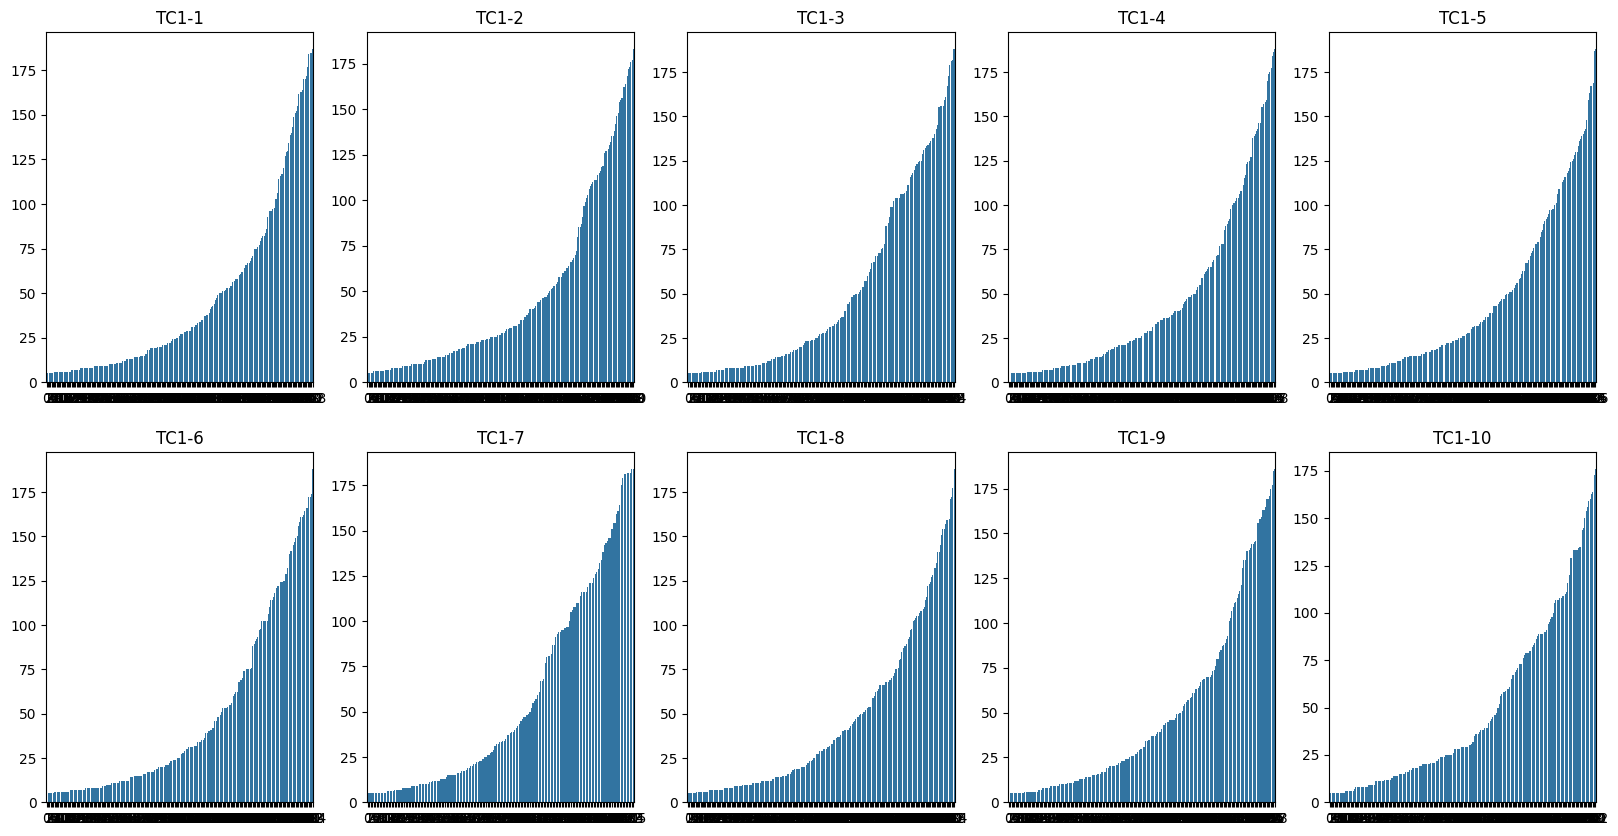

In [2]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for n in range(1, 11):

    base_path = f"dataset/TC1-{n}/1-{n}-c.dat"
    # load data
    answer = pd.read_csv(base_path, sep='\t', header=None)

    cluster_dict = {}
    # iloc answer
    answer_only = answer.iloc[:, 0:2].values

    for vtx, cluster in answer_only:
        if cluster not in cluster_dict:
            cluster_dict[cluster] = []
        cluster_dict[cluster].append(vtx)
        
    # sort cluster by size
    cluster_dict = sorted(cluster_dict.items(), key=lambda x: len(x[1]), reverse=False)

    # sorry for dirty reindexing
    new_cluster_dict = {}
    for i, (k,v) in enumerate(cluster_dict):
        new_cluster_dict[i] = v

    # plot by 2 row 5 column
    r = (n-1) // 5
    col = (n-1) % 5
    ax = axes[r, col]
    ax.set_title(f"TC1-{n}")
    sns.barplot(x=list(new_cluster_dict.keys()), y=[len(v) for v in new_cluster_dict.values()], ax=ax)
    
    
    
plt.savefig("TC1-clusterdistribution.png")    


In [3]:
def compute_centrality(graph):
    # betweenness
    betweenness = graph.betweenness()

    return max(betweenness) , np.mean(betweenness), np.std(betweenness)



In [4]:
from sklearn.metrics import normalized_mutual_info_score as nmi

modularities = []
init_nmis = []

for n in range(1, 11):
    
    base_path = f"dataset/TC1-{n}/1-{n}.dat"
    # load data
    data = np.loadtxt(base_path).astype(int)
    graph = ig.Graph(data, directed=False)

    # simple complexity measure
    v_count = len(graph.vs)
    e_count = len(graph.es)
    # maxcentrality = compute_centrality(graph)
    # max_cent, m_cent, std_cent = maxcentrality
    # z_cent = (max_cent - m_cent) / std_cent
    mean_degree = np.mean(graph.degree())
    max_degree = np.max(graph.degree())
    min_degree = np.min(graph.degree())


    initial_partition = la.find_partition(graph, la.ModularityVertexPartition, n_iterations=10, seed=7777)


    
    answer = pd.read_csv(f"dataset/TC1-{n}/1-{n}-c.dat", sep='\t', header=None)
    answer_only = answer.iloc[:, 0:2].values
    
    pred_labels = [0]* len(graph.vs)
    
    # pred label from initial partition
    for i, cluster in enumerate(initial_partition):
        for vtx in cluster:
            pred_labels[vtx] = i
    
    pred_labels = np.array(pred_labels)
    
    true_labels = np.zeros(len(graph.vs))
    for vtx, cluster in answer_only:
        true_labels[vtx] = cluster
    
    # calculate nmi
    nmi_score = nmi(true_labels, pred_labels)
    print(f"TC1-{n} NMI: {nmi_score},  modularirty: {initial_partition.modularity}")
    modularities.append(initial_partition.modularity)
    init_nmis.append(nmi_score)


 
        

TC1-1 NMI: 0.9527170688813746,  modularirty: 0.7874314090321572
TC1-2 NMI: 0.9481438726429259,  modularirty: 0.7375562427177226
TC1-3 NMI: 0.95091067775572,  modularirty: 0.6881366124978548
TC1-4 NMI: 0.9379348845262127,  modularirty: 0.6379902142268725
TC1-5 NMI: 0.9305492845803676,  modularirty: 0.5897826779536613
TC1-6 NMI: 0.9310973272806996,  modularirty: 0.5403225779618553
TC1-7 NMI: 0.9358301647614685,  modularirty: 0.48953883197271514
TC1-8 NMI: 0.8774175415369485,  modularirty: 0.39371067727515385
TC1-9 NMI: 0.5981269028933974,  modularirty: 0.2922653874517717
TC1-10 NMI: 0.12601463205324087,  modularirty: 0.2147626201552378


TC-1, cluster 0 smodularity: 0.17685091765377997
TC-1, cluster 5 smodularity: 0.15324591373331925
TC-1, cluster 7 smodularity: 0.1660893762996335
TC-1, cluster 16 smodularity: 0.1905035998486026
TC-1, cluster 18 smodularity: 0.16086376551060771
TC-1, cluster 20 smodularity: 0.1640455468410937
TC-1, cluster 27 smodularity: 0.5011441056083653
TC-1, cluster 31 smodularity: 0.23984719122353296
TC-1, cluster 38 smodularity: 0.7297927977839335
TC-1, cluster 41 smodularity: 0.1295746842792858
TC-1, cluster 48 smodularity: 0.16053632487880887
TC-1, cluster 50 smodularity: 0.36149681321540067
TC-1, cluster 56 smodularity: 0.15825754878798665
TC-1, cluster 57 smodularity: 0.4496506085427367
TC-1, cluster 65 smodularity: 0.6689875096450618
TC-1, cluster 66 smodularity: 0.15544199999999997
TC-1, cluster 67 smodularity: 0.3313840830449827
TC-1, cluster 76 smodularity: 0.610984519675926
TC-1, cluster 78 smodularity: 0.20058270919421492
TC-1, cluster 87 smodularity: 0.12212359807467943
TC-2, cluster 

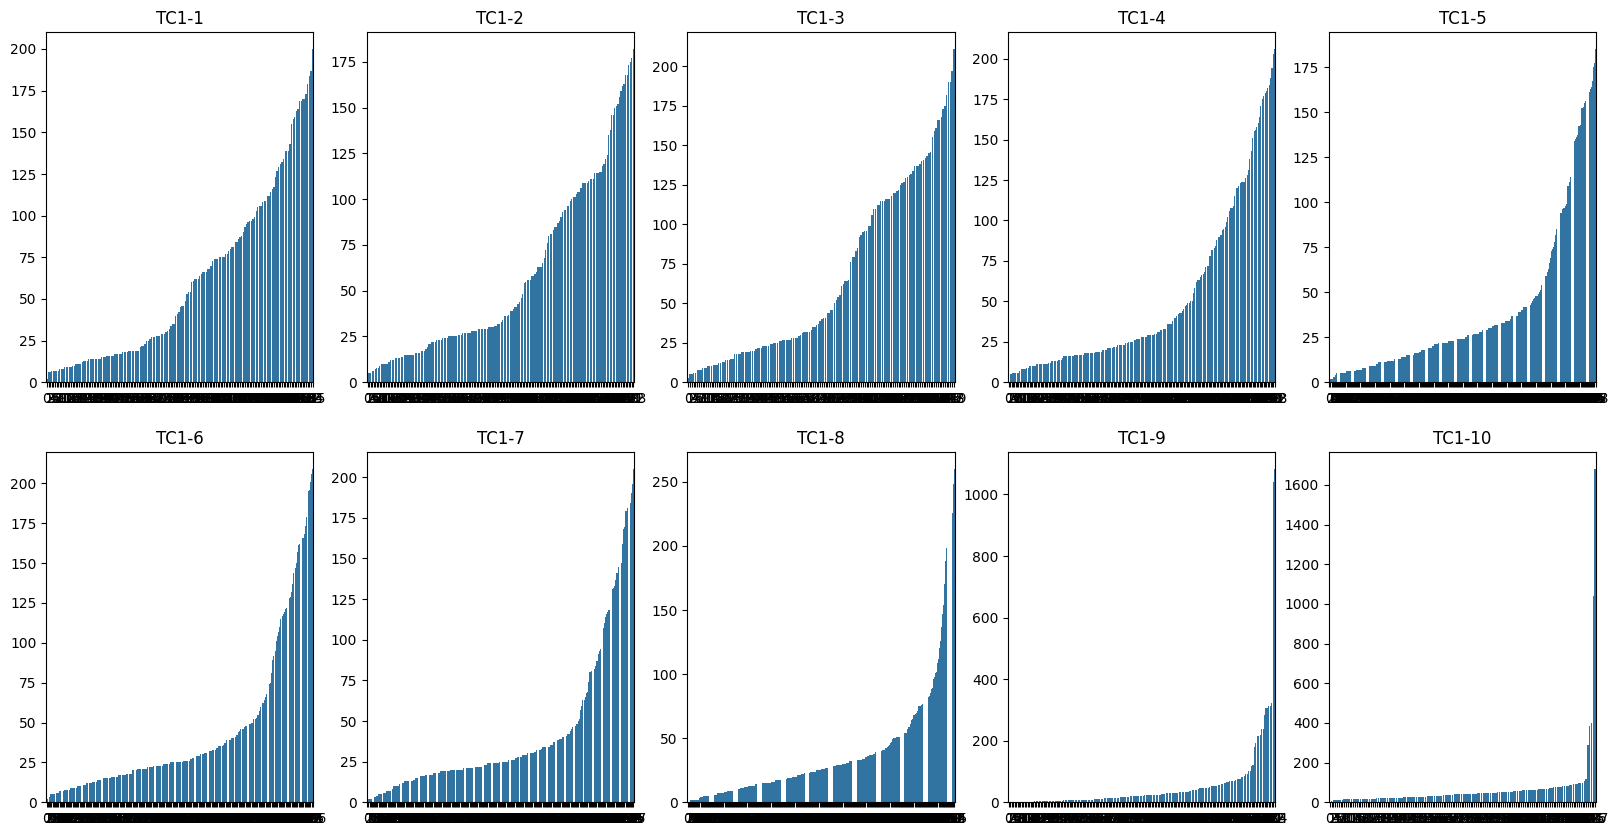

In [6]:
with open("TC1-Cluster.log", "a") as f:
    f.write(f"Splitting in modularity threshold\n")
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
for n in range(1, 11):
    
    base_path = f"dataset/TC1-{n}/1-{n}.dat"
    # load data
    data = np.loadtxt(base_path).astype(int)
    graph = ig.Graph(data, directed=False)
    init_partition = la.find_partition(graph, la.ModularityVertexPartition, n_iterations=10, seed=7777)
    vertices = graph.vcount()

    # print(f"Initially found {len(init_partition)} clusters")
    # print(f"Number of vertices: {vertices}")

    threshold = 1 - modularities[n-1]

    cluster_set = []
    n_of_valid_vertices = 0 
    for cluster_index, cluster_vertices in enumerate(init_partition):
        new_graph = []
        for index in range(len(data)):
            node1, node2 = data[index]
            assert node1 != node2
            if node1 in cluster_vertices and node2 in cluster_vertices:
                new_graph.append([node1, node2])
                # new_graph.append([node2, node1])
        new_graph = np.array(new_graph)
        unique_nodes, count = np.unique(new_graph, return_counts=True)
        
        # Mapping
        old2new = {}
        new2old = {}
        for i, node in enumerate(unique_nodes):
            old2new[node] = i
            new2old[i] = node
            
        new_vertices = np.array([[old2new[node1], old2new[node2]] for node1, node2 in new_graph])
        if len(new_vertices) == 0:
            # print(f'{cluster_index} is empty')
            continue
        
        if np.random.rand() > threshold:
            cluster_set.append(list(cluster_vertices))
            continue
        new_graph = ig.Graph(new_vertices, directed=False)
        sub_partition = la.find_partition(new_graph, la.ModularityVertexPartition, n_iterations=10, seed=7777)
        print(f"TC-{n}, cluster {cluster_index} sub modularity: {sub_partition.modularity}")
        n_of_valid_vertices += len(cluster_vertices)
       
        # if len(unique_nodes) != len(cluster_vertices):
        #     print(list(unique_nodes))
        #     print(cluster_vertices)
        check_assert_list = []
        for index, sub_vertices in enumerate(sub_partition):
            old_sub_vertices = []
            for new_vertex in sub_vertices:
                old_sub_vertices.append(new2old[new_vertex])
            check_assert_list.extend(old_sub_vertices)
            cluster_set.append(old_sub_vertices)

            assert len(old_sub_vertices) != 0
        
        check_assert = False
        assert len(check_assert_list) == len(list(old2new.keys()))
        for node1, node2 in zip(sorted(check_assert_list), sorted(list(old2new.keys()))):
            assert node1 == node2
    
    # after second leiden,
    # print(f"Now we found {len(cluster_set)} clusters")

    # Check NMI
    pred_labels = [0]* len(graph.vs)
    for i, cluster in enumerate(cluster_set):
        for vtx in cluster:
            pred_labels[vtx] = i
    
    pred_labels = np.array(pred_labels)

    answer = pd.read_csv(f"dataset/TC1-{n}/1-{n}-c.dat", sep='\t', header=None)
    answer_only = answer.iloc[:, 0:2].values
    true_labels = np.zeros(len(graph.vs))
    for vtx, cluster in answer_only:
        true_labels[vtx] = cluster
    
    # calculate nmi
    nmi_score = nmi(true_labels, pred_labels)

    # save to file, in mode : append
    with open("TC1-Cluster.log", "a") as f:
        f.write(f"TC1-{n} NMI: {nmi_score} vs initial NMI {init_nmis[n-1]}, initial {len(init_partition)} splitted to {len(cluster_set)} clusters\n")

    # sort cluster by size
    cluster_set = sorted(cluster_set, key=lambda x: len(x), reverse=False)
    # plot
    
    r = (n-1) // 5
    col = (n-1) % 5
    ax = axes[r, col]
    ax.set_title(f"TC1-{n}")
    sns.barplot(x=list(range(len(cluster_set))), y=[len(v) for v in cluster_set], ax=ax)

plt.savefig("TC1-clusterdistribution-split-modularity.png")

Initially found 94 clusters
Number of vertices: 10001
Initially found 90 clusters
Number of vertices: 10001
Initially found 83 clusters
Number of vertices: 10001
Initially found 84 clusters
Number of vertices: 10001
Initially found 78 clusters
Number of vertices: 10001
Initially found 74 clusters
Number of vertices: 10001
Initially found 68 clusters
Number of vertices: 10001
Initially found 58 clusters
Number of vertices: 10001
Initially found 35 clusters
Number of vertices: 10001
Initially found 16 clusters
Number of vertices: 10001


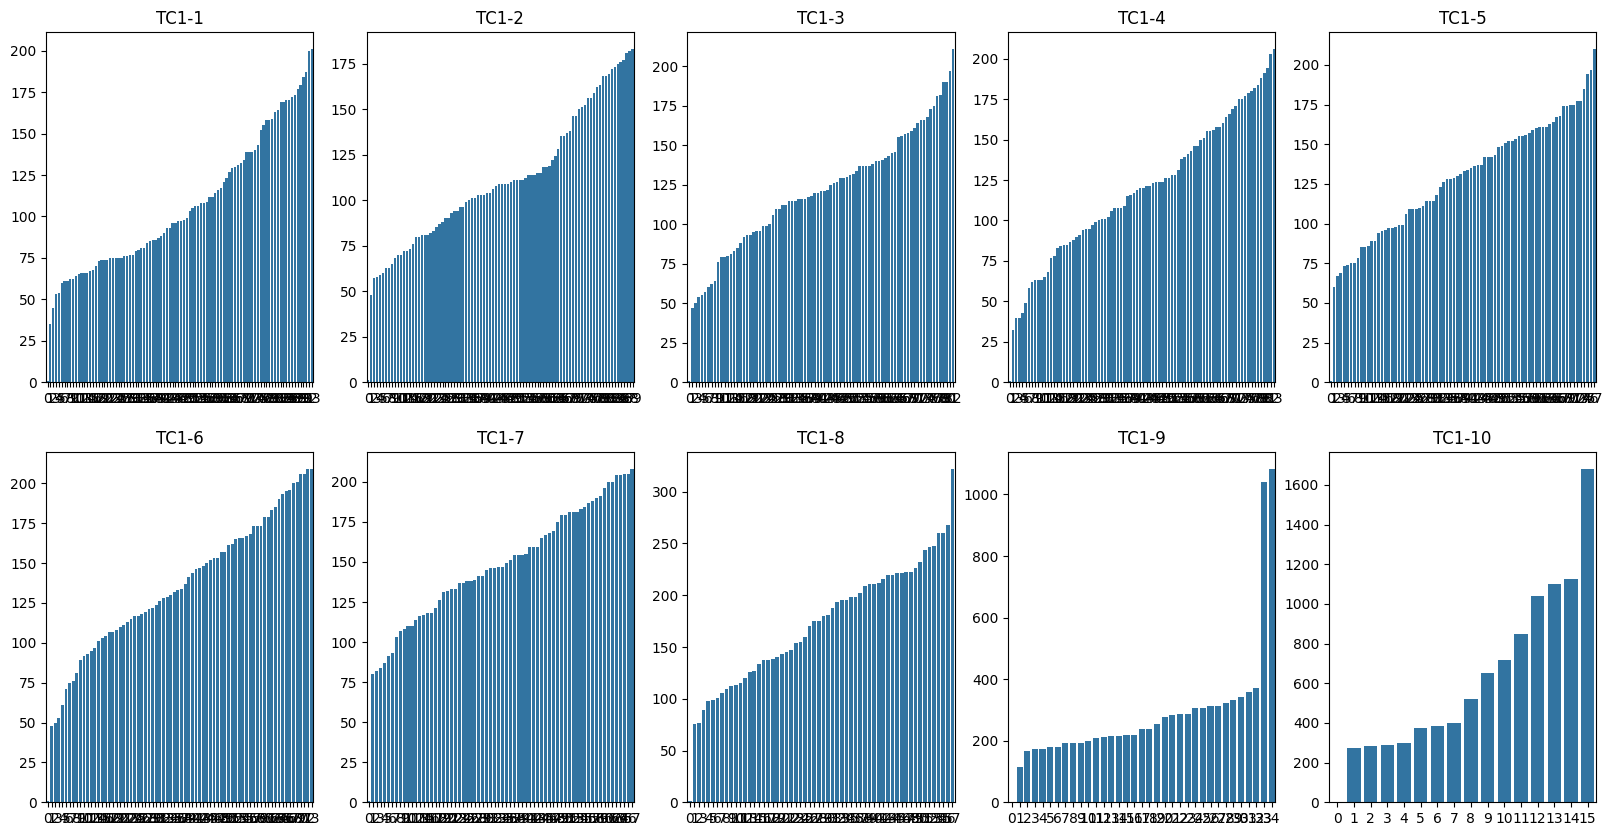

In [ ]:
# distribution of initial leiden
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
for n in range(1, 11):
    
    base_path = f"dataset/TC1-{n}/1-{n}.dat"
    # load data
    data = np.loadtxt(base_path).astype(int)
    graph = ig.Graph(data, directed=False)
    init_partition = la.find_partition(graph, la.ModularityVertexPartition, n_iterations=10, seed=7777)
    vertices = graph.vcount()

    print(f"Initially found {len(init_partition)} clusters")
    print(f"Number of vertices: {vertices}")

    # sort cluster by size
    init_partition = sorted(init_partition, key=lambda x: len(x), reverse=False)
    # plot
    
    r = (n-1) // 5
    col = (n-1) % 5
    ax = axes[r, col]
    ax.set_title(f"TC1-{n}")
    sns.barplot(x=list(range(len(init_partition))), y=[len(v) for v in init_partition], ax=ax)

plt.savefig("TC1-clusterdistribution-initial.png")